## Udacity's DSND Project 1: *"The future of Data Science positions: a look at the evolution of remote career options"*

Load the libraries used in the project. 

In [182]:
import pandas as pd 

import country_converter as coco 

import geopandas as gpd 

import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib import gridspec, rcParams, rcParamsDefault

Set the parameters for the plots. 

In [183]:
# Plots parameters 
rcParams.update(rcParamsDefault) 
plt.style.use(['ggplot'])
params = {
    'font.family' : "Times New Roman",
    'lines.markersize' :5,  
    'figure.facecolor' : 'w', 
    'lines.linewidth' : 1.6,
    'axes.titlesize' : 16,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'text.usetex': False,
    'figure.figsize': (5.4, 3.8) 
   }
rotate = 20
markersize=7
rcParams.update(params)

Fix the color palette for the plots. 

In [184]:
# Palette 
colors = ['#78C850', '#F08030', '#6890F0']

### Exploratory analysis of the dataset

Load the dataset of Data Science job salaries obtained from [Kaggle](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries?datasetId=2268489&sortBy=voteCount). 

In [185]:
df = pd.read_csv('./Data/ds_salaries.csv')

Print some info of the dataset. 

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


Explore the structure of the dataset. 

In [187]:
df.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


Drop the column *Unnamed: 0*, which has no relevant info. 

In [188]:
df = df.drop(columns = ['Unnamed: 0'])

Check if the dataset has any null value. 

In [189]:
#Checking for null values
df.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

We can check that the dataset has no null values, so we can start with the data transformations. 

### Data transformations

Now we start with the data transformations for the dataset in order to make it easier to work with later. More specifically, we will transform the abbreviations in the dataset into more comprehensible strings and categorize them.

First, we transform the experience level column, which has four different categories: *Entry-level, Mid-level, Senior-level* and *Executive-level*.  

In [190]:
experience_level_dict = {"EN": "Entry-level", "MI": "Mid-level", "SE": "Senior-level", "EX": "Executive-level"}

df['experience_level'] = df['experience_level'].map(experience_level_dict)

df['experience_level'] = pd.Categorical(df['experience_level'], categories = ['Entry-level', 'Mid-level', 'Senior-level', 'Executive-level'])

We do the same with the company size, which is divided in three different categories: *Small, medium* and *large*. 

In [191]:
company_size_dict = {"S":"Small", "M": "Medium", "L": "Large"}

df['company_size'] = df['company_size'].map(company_size_dict)

df['company_size'] = pd.Categorical(df['company_size'], categories = ['Small', 'Medium', 'Large'])

The employment type is divided into four different categories: *Full-time, part-time, contract* and *freelance*. 

In [192]:
employment_type_dict = {'FT': 'Full-time', 'PT': 'Part-time', 'CT':'Contract', 'FL':'Freelance'}

df['employment_type'] = df['employment_type'].map(employment_type_dict)

df['employment_type'] = pd.Categorical(df['employment_type'], categories = ['Full-time', 'Part-time', 'Contract', 'Freelance'])

Now, we deal with the *job_type* variable, which is the basis of the analysis. This variable is divided in three categories: *Remote, hybrid* and *presential*. 

In [193]:
remote_ratio_dict = {100: 'Remote', 50: 'Hybrid', 0: 'Presential'}

df['job_type'] = df['remote_ratio'].map(remote_ratio_dict)

df['job_type'] = pd.Categorical(df['job_type'], categories = ['Presential', 'Hybrid', 'Remote'])

Drop the *remote_ratio* column, which is no longer used in the project. 

In [194]:
df = df.drop(columns = ['remote_ratio'])

We define a function to categorize correctly the continents. 

In [218]:
def corrected_continent(continent, country): 
    """
    Function to categorize correctly the continents and corrects the result obtanied from the country_converter package function. 
    It allows to divide America in its two parts: North America and South America. 
    Args:
        continent [string]: continent name as returned from the country_converter package function. 
        country [string]: country name as returned from the country_converter package function. 

    Returns:
        continent [string]: corrected continent name
    """
    north_america_list = ['United States', 'Canada', 'Mexico']
    if continent == "America" and country in north_america_list: 
        return ("North America")
    elif continent == "America" and country not in north_america_list:
        return ("South America")
    else: 
        return (continent) 

Get the continent name for the *company_location* and *employee_residence* variables. 

In [196]:
df['company_location_name'] = coco.convert(df['company_location'], to = 'name_short')
df['company_location_continent'] = coco.convert(df['company_location'], to = 'continent')
df['company_location_continent'] = df.apply(lambda x: corrected_continent(x['company_location_continent'], x['company_location_name']), axis = 1)

df['employee_residence_name'] = coco.convert(df['employee_residence'], to = 'name_short')
df['employee_residence_continent'] = coco.convert(df['employee_residence'], to = 'continent')
df['employee_residence_continent'] = df.apply(lambda x: corrected_continent(x['employee_residence_continent'], x['employee_residence_name']), axis = 1)

Create the variables *different_continent* and *different_continent_string* that represent if an employee resides in the same continent that its company location. 

In [197]:
df['different_continent'] = df.apply(lambda x: 1 if x['employee_residence_continent'] != x['company_location_continent'] else 0, axis = 1)

df['different_continent_string'] = df.apply(lambda x: "Same continent" if x['employee_residence_continent'] == x['company_location_continent'] else "Different continent", axis = 1)

df['different_continent_string'] = pd.Categorical(df['different_continent_string'], categories = ['Same continent', 'Different continent'])

### Q1: Evolution of the remote percentage per year 

Calculate the percentage of remote work per year in the dataset 

In [198]:
# Count the total number of job_types per year 
df_year_job_type = df.groupby(['work_year','job_type'], as_index = False).size().rename(columns = {"size": "job_type_count"})
# Count the total number of jobs per year 
df_year= df.groupby(['work_year'], as_index = False).size().rename(columns = {"size": "year_count"})
# Merge the datasets 
df_year_job_type = df_year_job_type.merge(df_year, how = 'left')
# Calculate the percentage of job types per year 
df_year_job_type['per'] = df_year_job_type['job_type_count']/df_year_job_type['year_count']*100

Plot the barplot with the remote percentage per year in the dataset. 

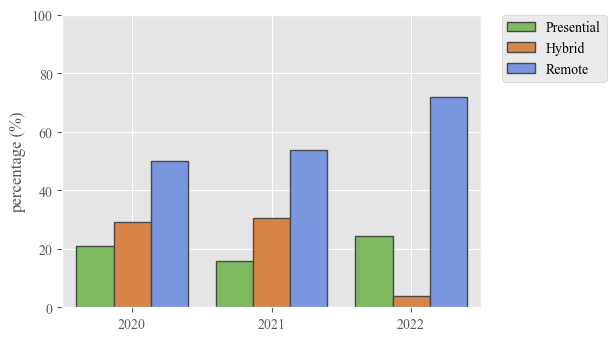

In [199]:
fig, ax = plt.subplots(1,1)
sns.barplot(x="work_year", y="per", data=df_year_job_type, hue = "job_type", palette = colors,\
            edgecolor = '#484848', linewidth = 1).grid(axis = 'y')
plt.grid()
plt.xlabel('')
plt.ylabel('percentage (%)')
plt.ylim([0,100])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Q2: Salary evolution per year  

Plot the boxplot with the salary per year in the dataset. 

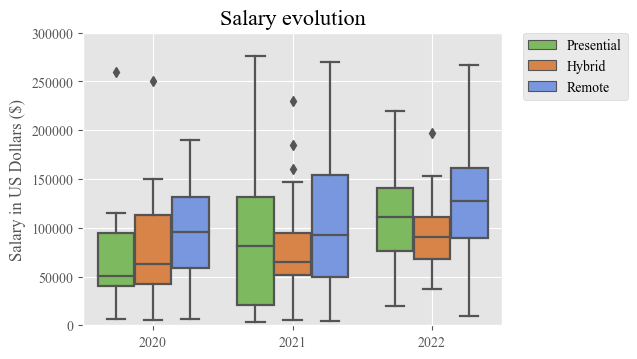

In [200]:
fig, ax = plt.subplots(1,1)
sns.boxplot(x = "work_year", y = "salary_in_usd", data = df, hue = "job_type", palette = colors).grid(axis = 'y')
plt.grid()
plt.xlabel('')
plt.ylabel('Salary in US Dollars ($)')
plt.ylim([0,300000])
plt.title('Salary evolution')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Q3: Mean salary per continent

Now, we load the *naturalearth_lowres* dataset, which is included in the *geopandas* package and allows to work with geographic data. 

In [201]:
# Load the 'naturalearth_lowres' dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Rename the columns of the dataset
world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']

Remove the Antarctica from the dataset.

In [202]:
world = world[(world.pop_est>0) & (world.name!="Antarctica")]

Calculate the mean salary in US Dollars($) for every continent. 

In [203]:
df_mean_salary = df.groupby(['company_location_continent'], as_index = False)['salary_in_usd'].mean()

Merge the salary and the geographic dataset. 

In [204]:
df_mean_salary = world.merge(df_mean_salary, how = 'left', left_on = 'continent', right_on = 'company_location_continent')

Plot a map with the mean salary per continent in USD($).

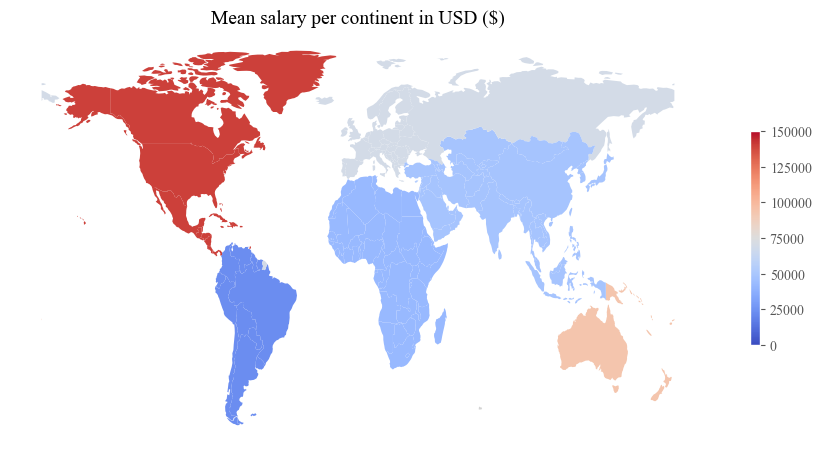

In [205]:
ax = df_mean_salary.plot(
    column="salary_in_usd",
    missing_kwds={'color': 'lightgrey'},
    vmin = 0, 
    vmax = 150000,
    legend=True,
    cmap = 'coolwarm',
    legend_kwds={
        "shrink":.2
    }, 
    figsize=(9, 11))
ax.set_axis_off()
plt.title('Mean salary per continent in USD ($)', fontsize = 14)
plt.tight_layout()
plt.show()

### Q4: Total number of employees per continent 

Calculate the total number of employees per continent. 

In [206]:
df_total_employees = df['company_location_continent'].value_counts().rename_axis('continent').reset_index(name='Total')

Merge the dataset with the geographic data. 

In [207]:
df_total_employees = world.merge(df_total_employees, how = 'left', on = 'continent')

Plot a map with the total number of employees per continent. 

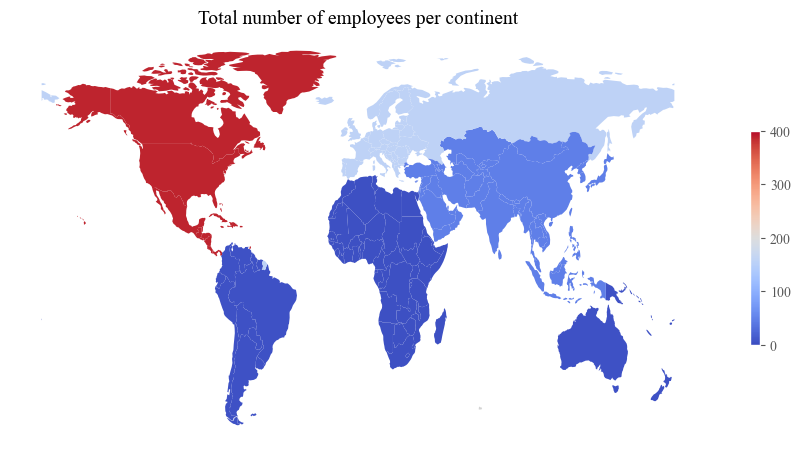

In [208]:
ax = df_total_employees.plot(
    column="Total",
    missing_kwds={'color': 'lightgrey'},
    vmin = 0, 
    vmax = 400,
    legend=True,
    cmap = 'coolwarm',
    legend_kwds={
        "shrink":.2
    }, 
    figsize=(9, 11))
ax.set_axis_off()
plt.title('Employees per continent', fontsize = 14)
plt.tight_layout()
plt.show()


### Q5: Number of employees working outside its residence continent per company location 

Calculate the total number of employees working outside its residence continent per company location. 

In [209]:
df_different_continent_company = df.groupby(['company_location_continent'], as_index = False)['different_continent'].sum()\
    .sort_values(by=['different_continent'],ascending = False)

Merge the dataset with the geographic info. 

In [210]:
df_different_continent_company = world.merge(df_different_continent_company, how = 'left', left_on = 'continent', right_on = 'company_location_continent')

Plot a map with the total number of employees working outside its residence continent per company location. 

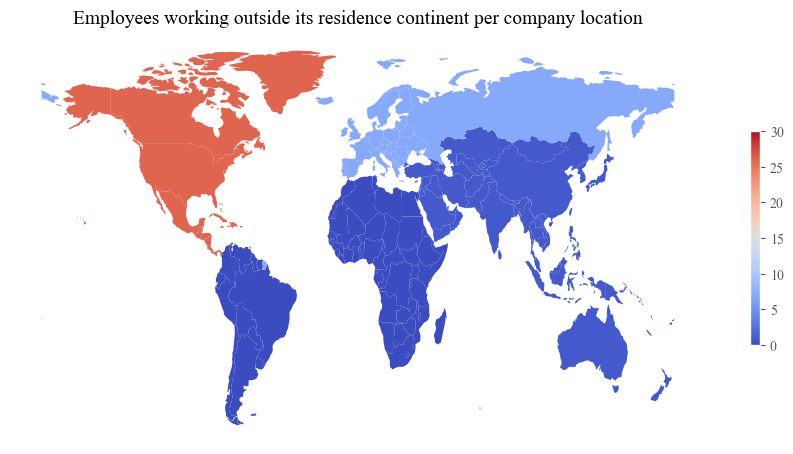

In [221]:
ax = df_different_continent_company.plot(
    column="different_continent",
    missing_kwds={'color': 'lightgrey'},
    vmin = 0, 
    vmax = 30,
    legend=True,
    cmap = 'coolwarm',
    legend_kwds={
        "shrink":.2
    }, 
    figsize=(9, 11))
ax.set_axis_off()
plt.title('Employees working outside its residence continent per company location', fontsize = 14)
plt.tight_layout()
plt.show()

### Q6: Total number of employees working outside its residence continent per employee residence. 

Calculate the total number of employees working outside its residence continent per employee residence. 

In [212]:
df_different_continent_employee = df.groupby(['employee_residence_continent'], as_index = False)['different_continent'].sum()\
    .sort_values(by=['different_continent'],ascending = False)

Merge the dataset with the geographic info. 

In [213]:
df_different_continent_employee = world.merge(df_different_continent_employee, how = 'left', left_on = 'continent', right_on = 'employee_residence_continent')

Plot a map with the total number of employees working outside its residence continent per employee residence. 

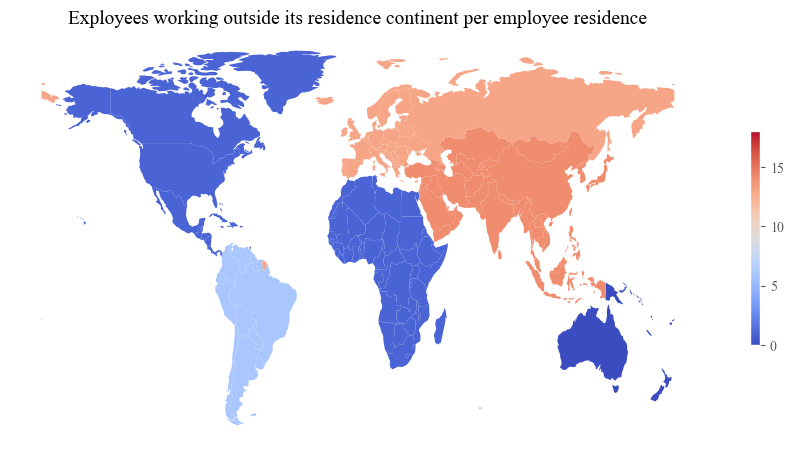

In [222]:
ax = df_different_continent_employee.plot(
    column="different_continent",
    missing_kwds={'color': 'lightgrey'},
    vmin = 0, 
    vmax = 18,
    legend=True,
    cmap = 'coolwarm',
    legend_kwds={
        "shrink":.2
    }, 
    figsize=(9, 11))
ax.set_axis_off()
plt.title('Exployees working outside its residence continent per employee residence', fontsize = 14)
plt.tight_layout()
plt.show()

### Q7: Salary comparative between the employees that are working in the same continent vs. other continent

Finally, we compare the salary between the employees that are working in the same continent they reside vs. the ones that are working in a different one. In particular, we explore it for Asia, Europe and South America, which are the three continents that have more employees working outside. 

Select the data for the three selected continents. 

In [215]:
continent_list = ['Asia', 'Europe', 'South America']

df_comparative_continent = df[df['employee_residence_continent'].isin(continent_list)].reset_index(drop = True)

df_comparative_continent['employee_residence_continent'] = pd.Categorical(df_comparative_continent['employee_residence_continent'], categories = ['Asia', 'Europe', 'South America'])

Plot a boxplot with the salary comparative. 

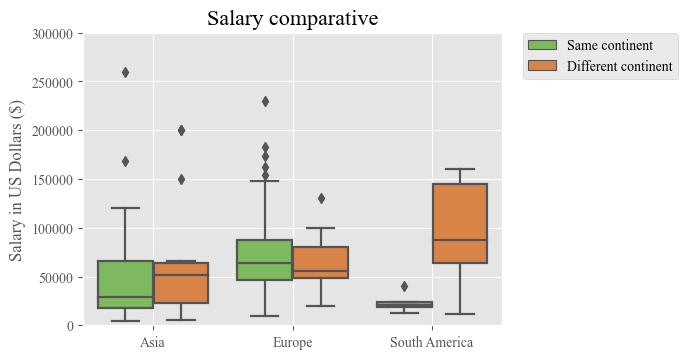

In [216]:
fig, ax = plt.subplots(1,1)
sns.boxplot(x = "employee_residence_continent", y = "salary_in_usd", data = df_comparative_continent, hue = "different_continent_string", palette = colors).grid(axis = 'y')
plt.grid()
plt.xlabel('')
plt.ylabel('Salary in US Dollars ($)')
plt.ylim([0,300000])
plt.title('Salary comparative')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()